# Visualizing the Model Mechanisms: Embeddings, Features, and Attention

In [1]:
cd /jet/home/skothare/F25-Deep-Learning-Project

/jet/home/skothare/F25-Deep-Learning-Project


/jet/home/skothare/.conda/envs/diffusion_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Your project imports
from models import UNet, VAE, ClassEmbedder, DiffusionTransformer
from schedulers import DDPMScheduler, DDIMScheduler
from pipelines import DDPMPipeline

import umap

from types import SimpleNamespace


In [ ]:
def load_from_checkpoint(ckpt_path, device="cpu"):
    """
    ckpt_path: full path to .../checkpoints/best.pt or last.pt
    Returns: args, model, vae, class_embedder, scheduler, pipeline
    """
    print(f"\nLoading checkpoint: {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)

    # Rebuild args as a namespace for convenience
    args_dict = ckpt["args"]
    args = SimpleNamespace(**args_dict)

    # Rebuild model exactly like in train.py 
    if getattr(args, "model_type", "unet") == "dit":
        print("  -> Using DiffusionTransformer backbone")
        model = DiffusionTransformer(
            input_size=args.unet_in_size,
            input_ch=args.unet_in_ch,
            T=args.num_train_timesteps,
            d_model=args.dit_d_model,
            depth=args.dit_depth,
            n_heads=args.dit_n_heads,
            patch_size=args.dit_patch_size,
            mlp_ratio=args.dit_mlp_ratio,
            conditional=args.use_cfg,
            c_dim=args.unet_ch,
        )
    else:
        print("  -> Using UNet backbone")
        model = UNet(
            input_size=args.unet_in_size,
            input_ch=args.unet_in_ch,
            T=args.num_train_timesteps,
            ch=args.unet_ch,
            ch_mult=args.unet_ch_mult,
            attn=args.unet_attn,
            num_res_blocks=args.unet_num_res_blocks,
            dropout=args.unet_dropout,
            conditional=args.use_cfg,
            c_dim=args.unet_ch,
        )

    model.load_state_dict(ckpt["unet"])
    model.to(device)
    model.eval()

    #  Optional VAE
    vae = None
    if getattr(args, "latent_ddpm", False) and "vae" in ckpt:
        print("  -> Loading VAE weights")
        vae = VAE()
        vae.load_state_dict(ckpt["vae"])
        vae.to(device)
        vae.eval()

    # ClassEmbedder (for CFG)
    class_embedder = None
    if getattr(args, "use_cfg", False) and "class_embedder" in ckpt:
        print("  -> Loading ClassEmbedder weights")
        class_embedder = ClassEmbedder(
            embed_dim=args.unet_ch,
            n_classes=args.num_classes,
        )
        class_embedder.load_state_dict(ckpt["class_embedder"])
        class_embedder.to(device)
        class_embedder.eval()

    # Scheduler (DDIM vs DDPM) 
    if getattr(args, "use_ddim", False):
        print("  -> Using DDIMScheduler")
        scheduler = DDIMScheduler(
            num_inference_steps=args.num_inference_steps,
            num_train_timesteps=args.num_train_timesteps,
            beta_start=args.beta_start,
            beta_end=args.beta_end,
            beta_schedule=args.beta_schedule,
            variance_type=args.variance_type,
            prediction_type=args.prediction_type,
            clip_sample=args.clip_sample,
            clip_sample_range=args.clip_sample_range,
        )
    else:
        print("  -> Using DDPMScheduler")
        scheduler = DDPMScheduler(
            num_inference_steps=args.num_inference_steps,
            num_train_timesteps=args.num_train_timesteps,
            beta_start=args.beta_start,
            beta_end=args.beta_end,
            beta_schedule=args.beta_schedule,
            variance_type=args.variance_type,
            prediction_type=args.prediction_type,
            clip_sample=args.clip_sample,
            clip_sample_range=args.clip_sample_range,
        )

    scheduler = scheduler.to(device)

    pipeline = DDPMPipeline(
        unet=model,
        scheduler=scheduler,
        vae=vae,
        class_embedder=class_embedder,
    )

    return args, model, vae, class_embedder, scheduler, pipeline


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"


EXP_DIRS = {
    "ddim":              "/jet/home/skothare/F25-Deep-Learning-Project/experiments/exp-9-SK-ddim-1633-06Dec/checkpoints/best.pt",
    "ddpm":              "/ocean/projects/cis250280p/jgupta2/experiments/exp-4-imagenet100_ddpm/checkpoints/best.pt",
    "ddim+vae+cfg":      "/jet/home/skothare/F25-Deep-Learning-Project/experiments/exp-4-SK-2100-04Dec/checkpoints/best.pt",
    "ddpm+cfg":          "/ocean/projects/cis250280p/dkilari/experiments/exp-23-exp-21-13-8_ddpm+cfg_12-7-6-cont2/checkpoints/best.pt",
    "ddpm+vae":          "/ocean/projects/cis250280p/dkilari/experiments/exp-22-exp-16-imagenet100__ddpm+vae_vaeVal_12-6/checkpoints/best.pt",
    "ddpm+vae+cfg":      "/ocean/projects/cis250280p/jgupta2/experiments/exp-2-imagenet100_ddpm/checkpoints/best.pt",
    "dit+vae+cfg_8h":    "/jet/home/skothare/F25-Deep-Learning-Project/experiments/exp-7-SK-dit_latent_cfg-1900-04Dec/checkpoints/best.pt",
    "dit+vae+cfg_12h":   "/jet/home/skothare/F25-Deep-Learning-Project/experiments/exp-11-SK-dit_latent_cfg-2218-05Dec/checkpoints/best.pt",
}


In [5]:
all_models = {}

for name, ckpt_path in EXP_DIRS.items():
    print(f"\nLoading model: {name} ")
    args, model, vae, class_emb, sched, pipe = load_from_checkpoint(ckpt_path, device=device)
    all_models[name] = {
        "args": args,
        "model": model,
        "vae": vae,
        "class_embedder": class_emb,
        "scheduler": sched,
        "pipeline": pipe,
        "ckpt_path": ckpt_path,
    }

print("\nLoaded models:", list(all_models.keys()))


Loading model: ddim 

Loading checkpoint: /jet/home/skothare/F25-Deep-Learning-Project/experiments/exp-9-SK-ddim-1633-06Dec/checkpoints/best.pt
  -> Using UNet backbone
  -> Using DDIMScheduler

Loading model: ddpm 

Loading checkpoint: /ocean/projects/cis250280p/jgupta2/experiments/exp-4-imagenet100_ddpm/checkpoints/best.pt
  -> Using UNet backbone
  -> Using DDPMScheduler

Loading model: ddim+vae+cfg 

Loading checkpoint: /jet/home/skothare/F25-Deep-Learning-Project/experiments/exp-4-SK-2100-04Dec/checkpoints/best.pt
  -> Using UNet backbone
  -> Loading VAE weights
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
  -> Loading ClassEmbedder weights
  -> Using DDIMScheduler

Loading model: ddpm+cfg 

Loading checkpoint: /ocean/projects/cis250280p/dkilari/experiments/exp-23-exp-21-13-8_ddpm+cfg_12-7-6-cont2/checkpoints/best.pt
  -> Using UNet backbone
  -> Loading 

In [6]:


try:
    import umap
    UMAP = umap.UMAP
    print("Using UMAP")
except ImportError:
    from sklearn.manifold import TSNE
    UMAP = TSNE
    print("umap-learn not installed; falling back to t-SNE.")
    
def get_class_embeddings_for_model(model_entry, max_classes=30, device="cpu"):
    """
    model_entry: one entry from all_models[name]
    Returns:
      emb: [K, D] numpy array of class embeddings
      class_ids: [K] numpy array of integer labels
    """
    args = model_entry["args"]
    class_embedder = model_entry["class_embedder"]
    if class_embedder is None:
        return None, None

    n_classes = getattr(args, "num_classes", 100)
    K = min(max_classes, n_classes)

    with torch.no_grad():
        ids = torch.arange(K, device=device)   # class ids 0..K-1
        emb = class_embedder(ids)              # [K, embed_dim]

    return emb.cpu().numpy(), ids.cpu().numpy()


Using UMAP


CFG models: ['ddim+vae+cfg', 'ddpm+cfg', 'dit+vae+cfg_8h', 'dit+vae+cfg_12h']


/jet/home/skothare/.conda/envs/diffusion_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/jet/home/skothare/.conda/envs/diffusion_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/jet/home/skothare/.conda/envs/diffusion_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/jet/home/skothare/.conda/envs/diffusion_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


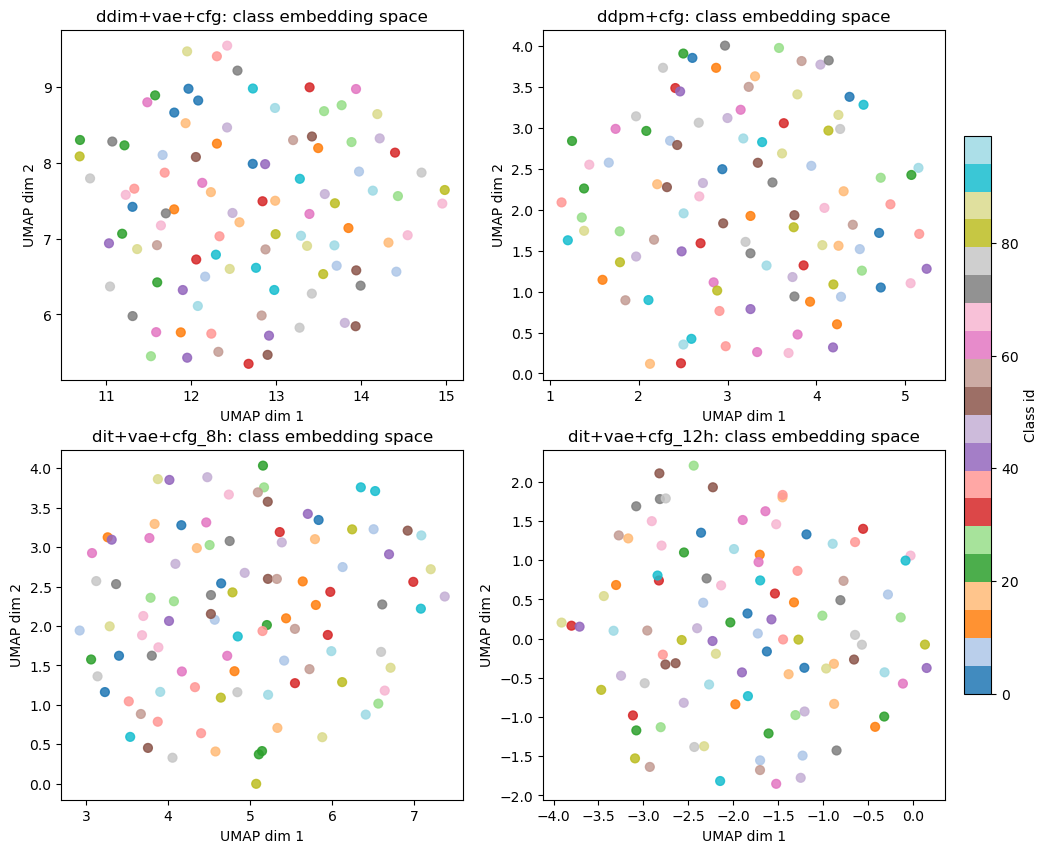

<Figure size 800x600 with 0 Axes>

In [7]:
# Filter to just CFG models (use_cfg=True AND we actually have a class_embedder)
cfg_models = {
    name: m for name, m in all_models.items()
    if getattr(m["args"], "use_cfg", False) and (m["class_embedder"] is not None)
}
print("CFG models:", list(cfg_models.keys()))

n_models = len(cfg_models)
ncols = 2
nrows = math.ceil(n_models / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
axes = np.array(axes).reshape(-1)  # flatten, in case of 1 row

for ax, (name, model_entry) in zip(axes, cfg_models.items()):
    emb, class_ids = get_class_embeddings_for_model(
        model_entry, max_classes=100, device=device
    )
    if emb is None:
        ax.set_visible(False)
        continue

    reducer = UMAP(n_components=2, random_state=42)
    emb_2d = reducer.fit_transform(emb)

    sc = ax.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=class_ids,
        cmap="tab20",
        s=40,
        alpha=0.85,
    )
    ax.set_title(f"{name}: class embedding space")
    ax.set_xlabel("UMAP dim 1")
    ax.set_ylabel("UMAP dim 2")

# Hide any unused subplots
for j in range(len(cfg_models), len(axes)):
    axes[j].set_visible(False)

#fig.colorbar(sc, ax=axes[:len(cfg_models)], label="Class id", shrink=0.8)

cbar = fig.colorbar(
    sc,
    ax=axes.ravel().tolist(),
    orientation='vertical',
    fraction=0.03, pad=0.02
)
cbar.set_label("Class id")
plt.figure(figsize=(8, 6))


plt.tight_layout()

plt.show()


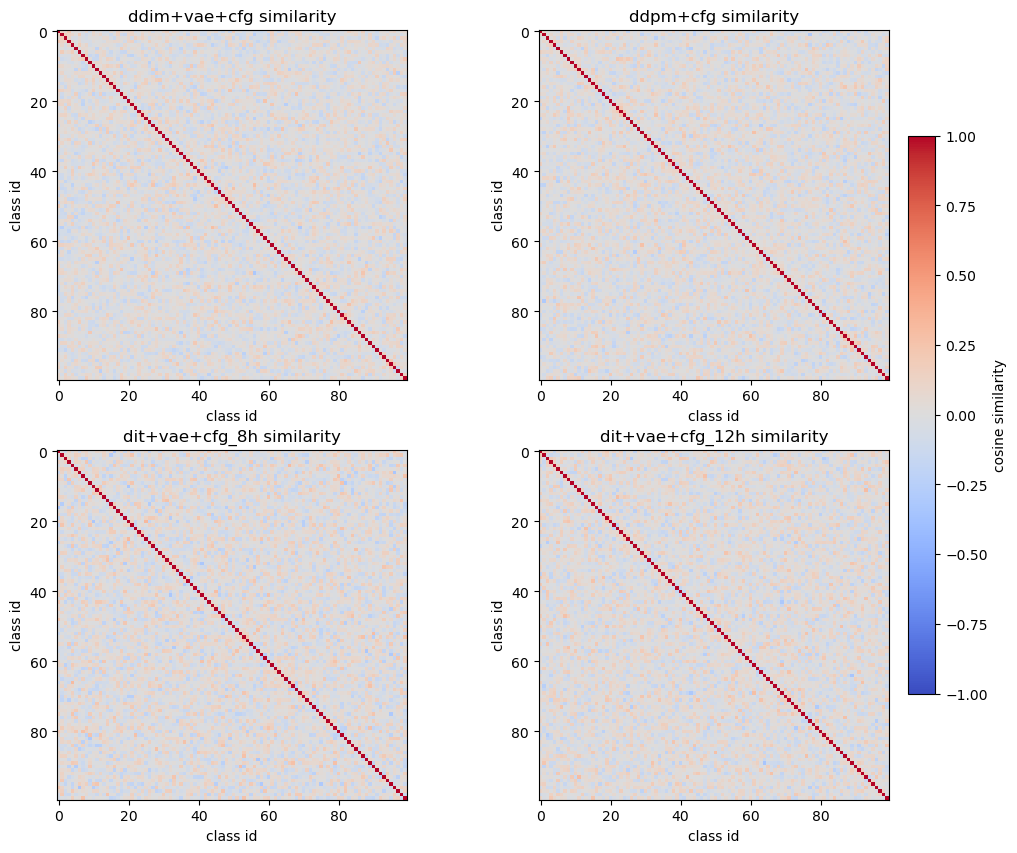

<Figure size 800x600 with 0 Axes>

In [8]:
def plot_all_class_sim_heatmaps(all_models, max_classes=30, device="cpu"):
    # Filter models that actually have class embedding
    cfg_models = {
        name: m for name, m in all_models.items()
        if getattr(m["args"], "use_cfg", False) and (m["class_embedder"] is not None)
    }

    model_names = list(cfg_models.keys())
    n = len(model_names)

    if n == 0:
        print("No CFG models with class_embedder found.")
        return

    # Grid shape (nice for papers)
    ncols = 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axes = np.array(axes).reshape(-1)  # flatten

    vmax = 1
    vmin = -1

    heatmaps = []

    for ax, (name, model_entry) in zip(axes, cfg_models.items()):
        args = model_entry["args"]
        class_embedder = model_entry["class_embedder"]

        n_classes = getattr(args, "num_classes", 100)
        K = min(max_classes, n_classes)

        with torch.no_grad():
            ids = torch.arange(K, device=device)
            emb = class_embedder(ids)  # [K, D]
            emb = emb / emb.norm(dim=1, keepdim=True)   # normalize
            sim = emb @ emb.T   # [K, K]

        sim_np = sim.cpu().numpy()
        im = ax.imshow(sim_np, vmin=vmin, vmax=vmax, cmap="coolwarm")
        
        ax.set_title(f"{name} similarity")
        ax.set_xlabel("class id")
        ax.set_ylabel("class id")

        heatmaps.append(im)

    # Hide leftover empty axes if any
    for i in range(len(cfg_models), len(axes)):
        axes[i].axis("off")

    # Shared colorbar
    cbar = fig.colorbar(
        heatmaps[0],
        ax=axes,
        orientation='vertical',
        fraction=0.03,
        pad=0.02
    )
    cbar.set_label("cosine similarity")

    plt.figure(figsize=(8, 6))
    plt.tight_layout()
    plt.show()

# call
plot_all_class_sim_heatmaps(all_models, max_classes=100, device=device)

## Diffusion Transformer Attention

In [ ]:
from types import SimpleNamespace
from models import DiffusionTransformer, VAE, ClassEmbedder
from schedulers import DDPMScheduler, DDIMScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"

def load_dit_with_components(ckpt_path, device="cpu"):
    print(f"Loading DiT checkpoint from: {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)

    # Rebuild args
    args = SimpleNamespace(**ckpt["args"])
    assert args.model_type == "dit", f"Expected DiT, got {args.model_type}"

    # Rebuild DiT exactly as in train.py 
    dit = DiffusionTransformer(
        input_size=args.unet_in_size,
        input_ch=args.unet_in_ch,
        T=args.num_train_timesteps,
        d_model=args.dit_d_model,
        depth=args.dit_depth,
        n_heads=args.dit_n_heads,
        patch_size=args.dit_patch_size,
        mlp_ratio=args.dit_mlp_ratio,
        conditional=args.use_cfg,
        c_dim=args.unet_ch,   # same as ClassEmbedder embed_dim
    )
    dit.load_state_dict(ckpt["unet"])
    dit.to(device).eval()

    #VAE (for latent_ddpm)
    vae = None
    if getattr(args, "latent_ddpm", False) and "vae" in ckpt:
        vae = VAE()
        vae.load_state_dict(ckpt["vae"])
        vae.to(device).eval()

    # Class embedder (for CFG) 
    class_embedder = None
    if getattr(args, "use_cfg", False) and "class_embedder" in ckpt:
        class_embedder = ClassEmbedder(
            embed_dim=args.unet_ch,
            n_classes=args.num_classes,
        )
        class_embedder.load_state_dict(ckpt["class_embedder"])
        class_embedder.to(device).eval()

    #  Scheduler (DDIM vs DDPM)
    if getattr(args, "use_ddim", False):
        print("  -> Using DDIMScheduler for DiT")
        scheduler = DDIMScheduler(
            num_inference_steps=args.num_inference_steps,
            num_train_timesteps=args.num_train_timesteps,
            beta_start=args.beta_start,
            beta_end=args.beta_end,
            beta_schedule=args.beta_schedule,
            variance_type=args.variance_type,
            prediction_type=args.prediction_type,
            clip_sample=args.clip_sample,
            clip_sample_range=args.clip_sample_range,
        )
    else:
        print("  -> Using DDPMScheduler for DiT")
        scheduler = DDPMScheduler(
            num_inference_steps=args.num_inference_steps,
            num_train_timesteps=args.num_train_timesteps,
            beta_start=args.beta_start,
            beta_end=args.beta_end,
            beta_schedule=args.beta_schedule,
            variance_type=args.variance_type,
            prediction_type=args.prediction_type,
            clip_sample=args.clip_sample,
            clip_sample_range=args.clip_sample_range,
        )

    scheduler = scheduler.to(device)

    return args, dit, vae, class_embedder, scheduler

# DiT checkpoints
CKPTS_DIT = {
    "dit+vae+cfg_8h":  "/jet/home/skothare/F25-Deep-Learning-Project/experiments/exp-7-SK-dit_latent_cfg-1900-04Dec/checkpoints/best.pt",
    "dit+vae+cfg_12h": "/jet/home/skothare/F25-Deep-Learning-Project/experiments/exp-11-SK-dit_latent_cfg-2218-05Dec/checkpoints/best.pt",
}

# Build dict-of-dicts: each entry has args/model/vae/class_embedder/scheduler
dit_models = {}
for name, path in CKPTS_DIT.items():
    args_dit, model_dit, vae_dit, class_emb_dit, sched_dit = load_dit_with_components(path, device)
    assert isinstance(args_dit, SimpleNamespace), f"args for {name} is not a SimpleNamespace!"
    dit_models[name] = {
        "args": args_dit,
        "model": model_dit,
        "vae": vae_dit,
        "class_embedder": class_emb_dit,
        "scheduler": sched_dit,
        "ckpt_path": path,
    }

print("Loaded DiT models:", list(dit_models.keys()))


Loading DiT checkpoint from: /jet/home/skothare/F25-Deep-Learning-Project/experiments/exp-7-SK-dit_latent_cfg-1900-04Dec/checkpoints/best.pt
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
  -> Using DDIMScheduler for DiT
Loading DiT checkpoint from: /jet/home/skothare/F25-Deep-Learning-Project/experiments/exp-11-SK-dit_latent_cfg-2218-05Dec/checkpoints/best.pt


making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
  -> Using DDIMScheduler for DiT
Loaded DiT models: ['dit+vae+cfg_8h', 'dit+vae+cfg_12h']


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def build_val_loader(args, max_samples=64):
    """
    args: SimpleNamespace loaded from checkpoint
    """
    tf = transforms.Compose([
        transforms.Resize((args.image_size, args.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
    ])
    # If args.val_dir is None, fallback to data_dir/validation
    val_dir = getattr(args, "val_dir", None) or args.data_dir.replace("/train", "/validation")
    print("Validation dir:", val_dir)

    ds = datasets.ImageFolder(root=val_dir, transform=tf)
    subset = torch.utils.data.Subset(ds, range(min(max_samples, len(ds))))
    loader = DataLoader(subset, batch_size=8, shuffle=False, num_workers=0)
    return loader, ds

# Use the args from *one* DiT as reference
first_entry = next(iter(dit_models.values()))
args_ref = first_entry["args"]
print("args_ref.image_size =", args_ref.image_size)

val_loader, val_ds = build_val_loader(args_ref, max_samples=64)
print("val_ds len:", len(val_ds))


args_ref.image_size = 128
Validation dir: /jet/home/jgupta2/hw5_student_starter_code/data/imagenet100_128x128/validation
val_ds len: 5000


In [11]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# To run one forward pass and save attention
def get_dit_attention_maps(
    model, vae, class_embedder, args,
    images, labels,
    device,
    layer_idx=0,
    t_scalar=None,
):
    """
    images: [B, 3, H, W] in pixel space, normalized [-1,1]
    labels: [B]
    Returns:
      attn_maps: [B, H_p, W_p] attention maps in patch space
    """
    model.eval()
    B = images.size(0)

    # 1) Latent encoding (because these DiTs are latent_ddpm=True)
    with torch.no_grad():
        z = vae.encode(images.to(device)) * 0.1845  # [B, C_latent, H_lat, W_lat]

    # 2) Choose timesteps
    if t_scalar is None:
        t_scalar = args.num_train_timesteps // 2  # mid diffusion step
    t = torch.full((B,), t_scalar, device=device, dtype=torch.long)

    # 3) Class embeddings for CFG models
    if args.use_cfg and class_embedder is not None:
        c = class_embedder(labels.to(device))
    else:
        c = None

    # 4) Tell only ONE layer to save attention
    for blk in model.blocks:
        blk.save_attn = False
        blk.attn_last_weights = None
    target_block = model.blocks[layer_idx]
    target_block.save_attn = True

    # 5) Forward pass – this will fill target_block.attn_last_weights
    with torch.no_grad():
        eps = model(z, t, c=c)

    attn = target_block.attn_last_weights  # [B, n_heads, N, N]

    # 6) Average over heads & query positions → single weight per token
    #    (many variants are possible; this is a simple, stable one)
    attn_avg = attn.mean(dim=1).mean(dim=1)   # [B, N]

    # 7) Reshape to [H_patches, W_patches]
    H_p = model.patch_embed.H_patches
    W_p = model.patch_embed.W_patches
    attn_maps = attn_avg.view(B, H_p, W_p)

    # 8) Normalize each map to [0,1] for visualization
    attn_maps = attn_maps - attn_maps.amin(dim=(1,2), keepdim=True)
    attn_maps = attn_maps / (attn_maps.amax(dim=(1,2), keepdim=True) + 1e-8)

    return attn_maps.cpu(), z.cpu()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def show_dit_attention_for_batch(
    name, args, model, vae, class_embedder,
    val_loader, device,
    layer_idx=0,
    t_scalar=None,
    n_examples=4,
):
    model.to(device)
    if vae is not None:
        vae.to(device)
    if class_embedder is not None:
        class_embedder.to(device)

    images, labels = next(iter(val_loader))
    images = images[:n_examples].to(device)
    labels = labels[:n_examples]

    # Get attention maps
    attn_maps, _ = get_dit_attention_maps(
        model, vae, class_embedder, args,
        images, labels,
        device=device,
        layer_idx=layer_idx,
        t_scalar=t_scalar,
    )

    # unsample to image size
    attn_tensor = attn_maps.unsqueeze(1)  # [B,1,H_p,W_p]
    attn_up = F.interpolate(
        attn_tensor,
        size=(args.image_size, args.image_size),
        mode="bilinear",
        align_corners=False,
    ).squeeze(1).cpu().numpy()  # [B, H, W]

    # Denormalize images
    imgs_np = images.cpu().numpy()
    imgs_np = (imgs_np * 0.5 + 0.5)   # [-1,1] → [0,1]

    # Figure
    fig, axes = plt.subplots(n_examples, 2, figsize=(7, 3*n_examples))
    fig.suptitle(f"DiT attention maps – {name}", fontsize=14)

    # Normalize single global scale for colorbar
    vmin = attn_up.min()
    vmax = attn_up.max()

    for i in range(n_examples):
        img = np.transpose(imgs_np[i], (1,2,0))
        att = attn_up[i]

        # Left panel: image
        ax0 = axes[i,0]
        ax0.imshow(img)
        ax0.axis("off")
        ax0.set_title(f"Class {labels[i].item()}")

        # Right panel: attention overlay
        ax1 = axes[i,1]
        ax1.imshow(img)
        heat = ax1.imshow(att, cmap="jet", alpha=0.5, vmin=vmin, vmax=vmax)
        ax1.axis("off")
        ax1.set_title("Attention")

    # ADD ONE COLORBAR FOR THE ENTIRE FIGURE 
    cbar = fig.colorbar(
        heat,
        ax=axes,
        shrink=0.7,
        location="right",
        label="attention weight"
    )
    plt.figure(figsize=(6, 5))
    plt.tight_layout()
    plt.show()


Attention visualization for dit+vae+cfg_8h


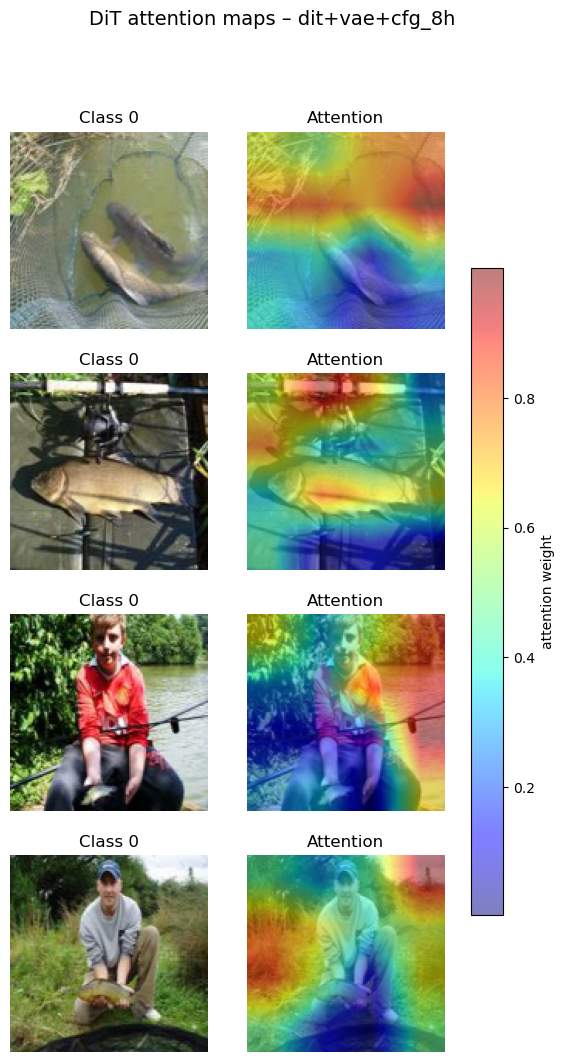

<Figure size 600x500 with 0 Axes>

Attention visualization for dit+vae+cfg_12h


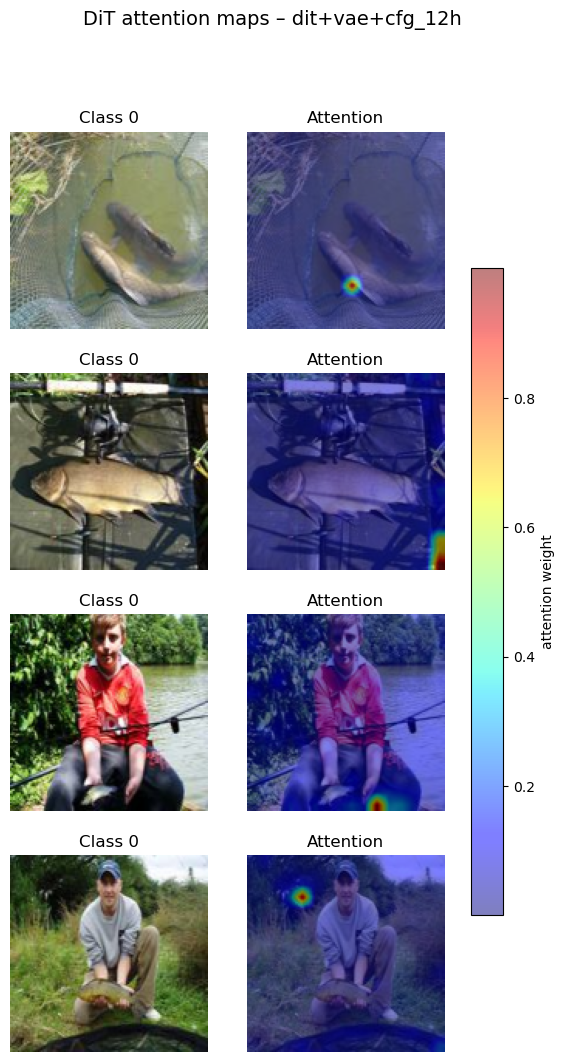

<Figure size 600x500 with 0 Axes>

In [13]:
for name, entry in dit_models.items():
    print(f"Attention visualization for {name}")
    show_dit_attention_for_batch(
        name=name,
        args=entry["args"],
        model=entry["model"],
        vae=entry["vae"],
        class_embedder=entry["class_embedder"],
        val_loader=val_loader,
        device=device,
        layer_idx=0,       # or try mid / last layers
        t_scalar=None,     # None = middle timestep
        n_examples=4,
    )


# Generate Denoising Trajectory GIFs


In [14]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import imageio.v2 as imageio
from PIL import Image
# From ChatGPT
os.makedirs("denoising_gifs", exist_ok=True)

LATENT_SCALE = 0.1845  # same as before
TARGET_SIZE = (128, 128)  # (W, H) for all GIFs; change if you want 256, etc.


def latents_to_images(x_t, args, vae):
    """
    Convert current model state x_t to pixel-space images in [0, 1].
    Handles both pixel-space DDPM and latent DDPM with VAE.
    Returns: np.array [B, H, W, C] in [0,1]
    """
    with torch.no_grad():
        if getattr(args, "latent_ddpm", False) and (vae is not None):
            imgs = vae.decode(x_t / LATENT_SCALE)
        else:
            imgs = x_t

        imgs = imgs.clamp(-1, 1)
        imgs = (imgs + 1.0) / 2.0

        imgs_np = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    return imgs_np


def resize_frame(frame, target_size=TARGET_SIZE):
    """
    frame: np.uint8 [H, W, C]
    target_size: (W, H)
    """
    pil_img = Image.fromarray(frame)
    pil_img = pil_img.resize(target_size, resample=Image.BILINEAR)
    return np.array(pil_img, dtype=np.uint8)


def make_denoising_frames_for_model(
    name,
    model_entry,
    batch_size=1,
    num_frames=16,
    class_id=0,
    save_individual_gif=True,
    out_dir="denoising_gifs",
):
    """
    Run reverse diffusion for a single model and return a list of resized frames.
    Optionally also saves an individual GIF for that model.

    Returns:
        frames: list of np.uint8 [H, W, C]
    """

    args        = model_entry["args"]
    model       = model_entry["model"]
    vae         = model_entry["vae"]
    scheduler   = model_entry["scheduler"]
    class_embed = model_entry["class_embedder"]

    model.to(device).eval()
    scheduler = scheduler.to(device)

    # (Re)set timesteps explicitly
    num_inference_steps = getattr(args, "num_inference_steps", scheduler.num_inference_steps)
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps

    # Noise in model input space
    x_t = torch.randn(
        batch_size,
        args.unet_in_ch,
        args.unet_in_size,
        args.unet_in_size,
        device=device,
    )

    n_steps = len(timesteps)
    save_indices = sorted(
        set(np.linspace(0, n_steps - 1, num_frames, dtype=int).tolist())
    )  # exactly num_frames

    frames = []

    if getattr(args, "use_cfg", False) and (class_embed is not None):
        labels = torch.full((batch_size,), class_id, device=device, dtype=torch.long)
    else:
        labels = None

    with torch.no_grad():
        for step_idx, t in enumerate(timesteps):
            t_batch = torch.full((batch_size,), int(t), device=device, dtype=torch.long)

            if labels is not None:
                c = class_embed(labels)
            else:
                c = None

            eps = model(x_t, t_batch, c=c)
            step_out = scheduler.step(eps, t, x_t)

            # handle different return types
            if isinstance(step_out, dict):
                x_t = step_out["prev_sample"]
            elif isinstance(step_out, (tuple, list)):
                x_t = step_out[0]
            else:
                x_t = step_out

            if step_idx in save_indices:
                imgs = latents_to_images(x_t, args, vae)
                frame = (imgs[0] * 255).astype(np.uint8)  # first sample
                frame = resize_frame(frame, TARGET_SIZE)
                frames.append(frame)

    # sanity: ensure frames == num_frames
    if len(frames) != len(save_indices):
        print(f"[WARN] {name}: expected {len(save_indices)} frames, got {len(frames)}")

    # Save individual GIF (all now the same size)
    if save_individual_gif:
        gif_path = os.path.join(out_dir, f"{name}_class{class_id}_denoising.gif")
        imageio.mimsave(gif_path, frames, duration=0.4)
        print(f"Saved per-model GIF for {name} → {gif_path}")

    return frames


In [15]:
model_frames = {}  # store frames for later tiling

for model_name, model_entry in all_models.items():
    print(f"\n=== Generating denoising frames for: {model_name} ===")
    frames = make_denoising_frames_for_model(
        name=model_name,
        model_entry=model_entry,
        batch_size=1,
        num_frames=16,
        class_id=0,
        save_individual_gif=True,
        out_dir="denoising_gifs",
    )
    model_frames[model_name] = frames



=== Generating denoising frames for: ddim ===


Saved per-model GIF for ddim → denoising_gifs/ddim_class0_denoising.gif

=== Generating denoising frames for: ddpm ===


/jet/home/skothare/F25-Deep-Learning-Project/schedulers/scheduling_ddpm.py:331: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  variance = torch.tensor(self._get_variance(t), device=model_output.device, dtype=model_output.dtype)


Saved per-model GIF for ddpm → denoising_gifs/ddpm_class0_denoising.gif

=== Generating denoising frames for: ddim+vae+cfg ===
Saved per-model GIF for ddim+vae+cfg → denoising_gifs/ddim+vae+cfg_class0_denoising.gif

=== Generating denoising frames for: ddpm+cfg ===
Saved per-model GIF for ddpm+cfg → denoising_gifs/ddpm+cfg_class0_denoising.gif

=== Generating denoising frames for: ddpm+vae ===
Saved per-model GIF for ddpm+vae → denoising_gifs/ddpm+vae_class0_denoising.gif

=== Generating denoising frames for: ddpm+vae+cfg ===
Saved per-model GIF for ddpm+vae+cfg → denoising_gifs/ddpm+vae+cfg_class0_denoising.gif

=== Generating denoising frames for: dit+vae+cfg_8h ===
Saved per-model GIF for dit+vae+cfg_8h → denoising_gifs/dit+vae+cfg_8h_class0_denoising.gif

=== Generating denoising frames for: dit+vae+cfg_12h ===
Saved per-model GIF for dit+vae+cfg_12h → denoising_gifs/dit+vae+cfg_12h_class0_denoising.gif


In [16]:
def make_panel_gif(
    model_frames,
    panel_path="denoising_gifs/all_models_panel.gif",
    n_cols=3,
    duration=0.4,
):
    """
    model_frames: dict {model_name: [frames]}
      each frames[i] is np.uint8 [H, W, C] (same size for all models)
    n_cols: number of columns in the panel grid
    """

    # Fix order of models (sorted for reproducibility, or custom order)
    model_names = sorted(model_frames.keys())
    num_models = len(model_names)
    custom_order = [
    "ddpm",
    "ddim",
    "ddpm+vae",
    "ddpm+cfg",
    "ddpm+vae+cfg",
    "ddim+vae+cfg",
    "dit+vae+cfg_8h",
    "dit+vae+cfg_12h",
    ]
    model_names = [m for m in custom_order if m in model_frames]


    # assume all models have same number of frames; be safe and take min
    num_frames = min(len(model_frames[m]) for m in model_names)

    # frame shape
    H, W, C = model_frames[model_names[0]][0].shape

    n_rows = int(np.ceil(num_models / n_cols))
    panel_frames = []

    for t in range(num_frames):
        # blank canvas (white background)
        panel = np.ones(
            (n_rows * H, n_cols * W, C), dtype=np.uint8
        ) * 255

        for idx, name in enumerate(model_names):
            r = idx // n_cols
            c = idx % n_cols
            frame = model_frames[name][t]  # [H, W, C]
            y0, y1 = r * H, (r + 1) * H
            x0, x1 = c * W, (c + 1) * W
            panel[y0:y1, x0:x1, :] = frame

        panel_frames.append(panel)

    imageio.mimsave(panel_path, panel_frames, duration=duration)
    print(f"Saved panel GIF → {panel_path}")


# Create the tiled GIF
make_panel_gif(
    model_frames,
    panel_path="denoising_gifs/all_models_panel.gif",
    n_cols=3,   # change to 2, 3, 4 depending on how many models you have
    duration=0.4,
)


Saved panel GIF → denoising_gifs/all_models_panel.gif
